# Principal Component Analysis for vibe composition survey responses

This notebook performs a PCA for the responses to the vibe composition survey. It takes a csv containing survey responses, plots the compoent variance of the survey responses, then plots a 1D and 3D PCA.

In [29]:
import plotly.graph_objects as go 
import plotly.express as px 
import pandas as pd 
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform


project_fldr = r''    # for saving figs

full_df = pd.read_csv(r'C:\Users\ellen\OneDrive\Documents\projects\vibe_composition\personality-survey-friends.csv')  # df containing the raw survey responses
full_df['first_inits'] = [name[0:2] for name in full_df['Name_First Name']]  # add a column for first 2 letters of first name

# drop all the columns apart from direct numerical survey responses and name
res_df = full_df.drop(['uuid','IP Address', 'Time Taken', 'Name_Last Name', 'created_at','Name_First Name'], axis='columns')
res_df.head()

,I prefer planning to spontaneity,I analyze practical problems from many angles before acting,"I have refined tastes (in food, in fashion, or in design, etc.)",I am detail-oriented,I am strategic about the way I manage and prioritize my social relationships,I value my intelligence over my perceived sense of humor,I often act on gut feelings rather than detailed analysis,I have strong emotional reactions to things,I feel restless when I have to sit still for too long,My life can feel chaotic and/or messy,I derive my energy from building community,I value loyalty to others above my own individual needs,I am subject to whimsy,I am easygoing and have a chill disposition,"I often enjoy ""winging it"" over preparing for new experiences",I value freedom in my schedule over being known for reliability,It's easy for me to feel comfortable in a new environment,I enjoy vibing with strangers as much as with friends (or more),first_inits
0,3,4,3,5,4,4,2,5,2,2,5,1,1,1,1,2,1,5,El
1,4,4,3,1,1,4,3,1,4,4,2,3,4,4,5,4,4,4,Be
2,5,3,3,4,3,3,4,2,3,1,3,2,5,5,2,2,2,4,Ju
3,3,5,5,4,5,3,1,1,4,5,5,4,2,4,4,2,4,1,Wa
4,1,2,4,5,4,2,4,2,4,4,5,4,2,4,5,2,1,1,Ka


### Quick and dirty plot of the variance by number of components

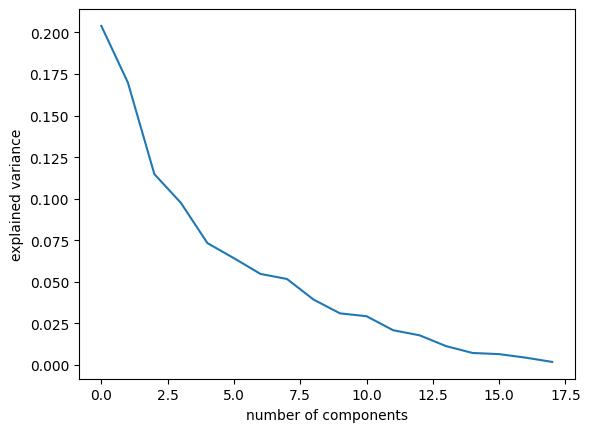

In [30]:
def plot_component_variance(res_df):
    data = res_df.drop(['first_inits'], axis='columns')   # a df used for the PCA -- survey responses only
    pca = PCA().fit(data)
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('number of components')
    plt.ylabel('explained variance')
    plt.show()

plot_component_variance(res_df)

### Plot 1D PCA to look at dimension with largest variance

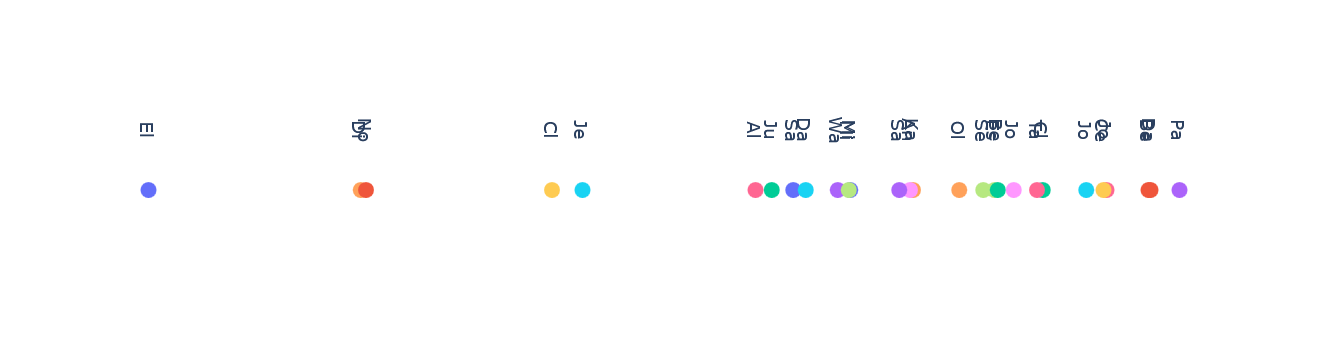

In [31]:
def plot_1d_pca(res_df, full_df):
    # Perform PCA
    data = res_df.drop(['first_inits'], axis='columns')
    pca = PCA(n_components=1)
    fit_pca = pca.fit(data)
    reduced = fit_pca.transform(data)
 
    y_vals = np.full(reduced.shape, 0.5)    
    fig = go.Figure()
    
    for idx, row in full_df.iterrows():
        name = row['first_inits']
        fig.add_trace(
            go.Scatter(name = '', # for hover formatting
                y=[y_vals[idx][0]],
                x=[reduced[idx][0]],
                mode='markers',
                showlegend=False,
                marker=dict(size=16),
                hovertemplate=f'{name}'))
        
        fig.add_annotation(
            x=reduced[idx][0],
            y=y_vals[idx][0],
            text=row['first_inits'],
            showarrow=False,
            textangle=90,
            yshift=60,
            font=dict(size=18))
    
    fig.update_layout(
        xaxis=dict(
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            showline=False,
            title=None),
        yaxis=dict(
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            showline=False,
            title=None),
        plot_bgcolor='white', 
        hoverlabel=dict(bgcolor="white", font_size=18))
    
    fig.write_html(os.path.join(project_fldr, 'PCA_1D.html'))
    return fig

plot_1d_pca(res_df, full_df)

### 3D PCA

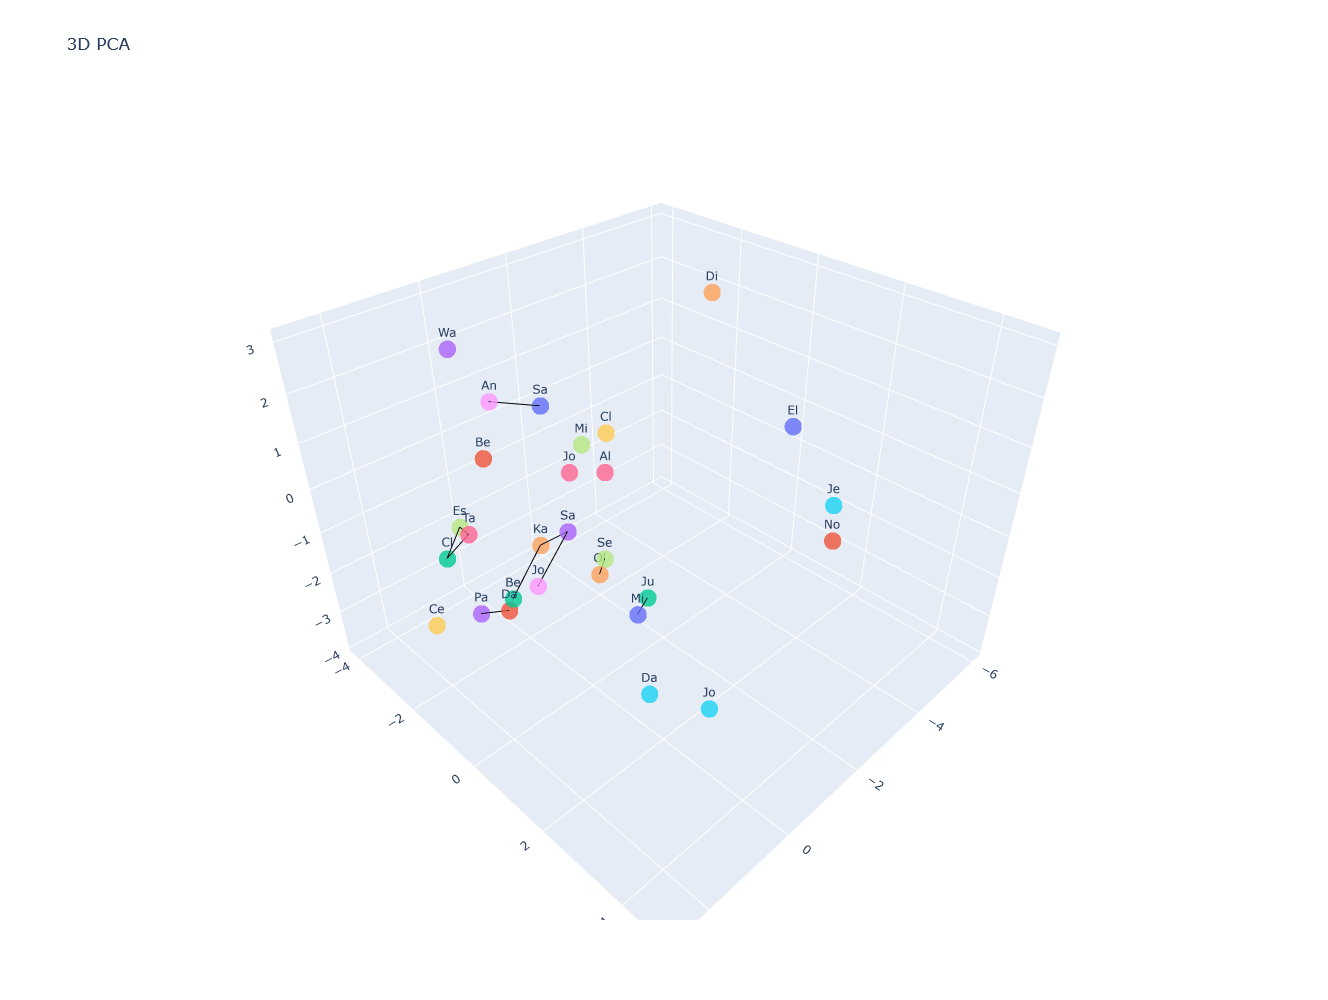

In [32]:
def plot_3D_PCA_plotly(res_df, full_df, project_fldr, n_connections=10):
    data = res_df.drop(['first_inits'], axis='columns')
    pca = PCA(n_components=3)
    fit_pca = pca.fit(data)
    reduced = fit_pca.transform(data)
    
    # calculate distances between all points to draw lines between closest pairs in 3D
    distances = pdist(reduced)
    dist_matrix = squareform(distances)
    dist_matrix_copy = dist_matrix.copy()
    np.fill_diagonal(dist_matrix_copy, np.inf) # avoid matching to self (fill diagonal of matrix with inf)
    closest_pairs = []
    
    for _ in range(n_connections): # default 10
        min_idx = np.unravel_index(np.argmin(dist_matrix_copy), dist_matrix_copy.shape)
        closest_pairs.append(min_idx)
        dist_matrix_copy[min_idx] = np.inf   # set to inf after appending closest_pairs to find the next closest... 
        dist_matrix_copy[min_idx[1], min_idx[0]] = np.inf
    
    fig = go.Figure()
    for i in range(len(full_df)):
        fig.add_trace(
            go.Scatter3d(
                x=[reduced[i,0]],
                y=[reduced[i,1]],
                z=[reduced[i,2]],
                mode='markers+text',
                name='',
                text=[full_df['first_inits'][i]],
                textposition='top center',
                hovertemplate=f"<b>{full_df['first_inits'][i]}</b>",
                marker=dict(
                    size=10,
                    opacity=0.8), 
                textfont_size =12,))
    
    # draw lines between closest pairs
    for pair in closest_pairs:
        i, j = pair
        fig.add_trace(
            go.Scatter3d(
                x=[reduced[i,0], reduced[j,0]],
                y=[reduced[i,1], reduced[j,1]],
                z=[reduced[i,2], reduced[j,2]],
                mode='lines',
                line=dict(color='black', width=2),
                hovertemplate=f"Distance: {dist_matrix[i,j]:.2f}<br>" +
                             f"Points: {full_df['first_inits'][i]} - {full_df['first_inits'][j]}",
                showlegend=False))
    
    fig.update_layout(
        title="3D PCA",
        scene=dict(
            xaxis_title="",
            yaxis_title="",
            zaxis_title=""),
        showlegend=False,
        height=1000
    )
    
    fig.write_html(os.path.join(project_fldr, 'PCA_3D.html'))
    fig.show()

plot_3D_PCA_plotly(res_df, full_df, project_fldr)